In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
openai_data = pd.read_parquet("./llm_data/rq4_validation_evidence_openai.parquet")
gemini_data = pd.read_parquet("./llm_data/rq4_validation_evidence_gemini.parquet")

In [4]:
len(openai_data), len(gemini_data)

(407, 407)

In [17]:
from pathlib import Path

# Load the non-meaningful IDs
agent_not_meaningful_path = Path("./agent_not_meaningful_ids.txt")
human_not_meaningful_path = Path("./human_not_meaningful_ids.txt")
# check if the files exist
if not agent_not_meaningful_path.exists() or not human_not_meaningful_path.exists():
    print(f"Error: {agent_not_meaningful_path} or {human_not_meaningful_path} does not exist")
    exit(1)
agent_not_meaningful_ids = set()
human_not_meaningful_ids = set()
print(f"Loading non-meaningful IDs from {agent_not_meaningful_path} and {human_not_meaningful_path}")

if agent_not_meaningful_path.exists():
    with open(agent_not_meaningful_path, 'r') as f:
        agent_not_meaningful_ids = set(line.strip() for line in f if line.strip())

if human_not_meaningful_path.exists():
    with open(human_not_meaningful_path, 'r') as f:
        human_not_meaningful_ids = set(line.strip() for line in f if line.strip())

# Combine all non-meaningful IDs
all_not_meaningful_ids = agent_not_meaningful_ids | human_not_meaningful_ids

# Filter out non-meaningful IDs from both dataframes
openai_data = openai_data[~openai_data['pr_id'].astype(str).isin(all_not_meaningful_ids)]
gemini_data = gemini_data[~gemini_data['pr_id'].astype(str).isin(all_not_meaningful_ids)]

print(f"Filtered out {len(all_not_meaningful_ids)} non-meaningful IDs")
print(f"Remaining OpenAI rows: {len(openai_data)}")
print(f"Remaining Gemini rows: {len(gemini_data)}")

Loading non-meaningful IDs from agent_not_meaningful_ids.txt and human_not_meaningful_ids.txt
Filtered out 50 non-meaningful IDs
Remaining OpenAI rows: 357
Remaining Gemini rows: 357


In [18]:
print("=== OPENAI DATA ===")
print(f"Rows: {len(openai_data)}")

print("Authors:", openai_data["author_type"].value_counts().to_dict())

print("validation_present counts:")
print(openai_data["validation_present"].value_counts(dropna=False))

print("validation_type counts:")
print(openai_data["validation_type"].value_counts(dropna=False))

=== OPENAI DATA ===
Rows: 357
Authors: {'ai_agent': 280, 'human': 77}
validation_present counts:
validation_present
True     210
False    147
Name: count, dtype: int64
validation_type counts:
validation_type
none               147
static-analysis    143
benchmark           56
profiling            6
anecdotal            5
Name: count, dtype: int64


In [19]:
print("\n=== GEMINI DATA ===")
print(f"Rows: {len(gemini_data)}")

print("Authors:", gemini_data["author_type"].value_counts().to_dict())

print("validation_present counts:")
print(gemini_data["validation_present"].value_counts(dropna=False))

print("validation_type counts:")
print(gemini_data["validation_type"].value_counts(dropna=False))


=== GEMINI DATA ===
Rows: 357
Authors: {'ai_agent': 280, 'human': 77}
validation_present counts:
validation_present
True     181
False    176
Name: count, dtype: int64
validation_type counts:
validation_type
none               176
static-analysis    107
benchmark           55
anecdotal           13
profiling            6
Name: count, dtype: int64


In [20]:

    # ============================================================
    # Cohen's Kappa agreement between OpenAI and Gemini labels
    # ============================================================
    !pip3 install scikit-learn
    from sklearn.metrics import cohen_kappa_score
    from pathlib import Path

    def _compute_kappa_stats(openai_df, gemini_df, comparisons, candidate_keys=None):
        if candidate_keys is None:
            candidate_keys = [
                ["id"],
                ["issue_url"],
                ["html_url"],
                ["url"],
                ["pr_url"],
                ["pull_request_url"],
                ["pr_id"],
                ["repo_owner", "repo_name", "pr_number"],
                ["repo_owner", "repo", "pr_number"],
                ["repo_name", "pr_number"],
                ["repo", "pr_number"],
                ["repo", "pr_title"],
            ]

        def _has_all(df, cols):
            return all(col in df.columns for col in cols)

        key_cols = None
        for cols in candidate_keys:
            if _has_all(openai_df, cols) and _has_all(gemini_df, cols):
                key_cols = cols
                break

        if key_cols is None:
            shared = sorted(set(openai_df.columns) & set(gemini_df.columns))
            raise ValueError(f"No shared identifier columns found. Common columns: {shared}")

        subset_cols = list(dict.fromkeys(list(key_cols) + list(comparisons.keys())))
        merged = (
            openai_df[subset_cols]
            .merge(
                gemini_df[subset_cols],
                on=key_cols,
                suffixes=("_openai", "_gemini"),
                how="inner",
            )
        )

        stats = {}
        for col, normalizer in comparisons.items():
            left = normalizer(merged[f"{col}_openai"])
            right = normalizer(merged[f"{col}_gemini"])
            match_rate = float((left == right).mean()) if len(left) else float("nan")
            stats[col] = {
                "kappa": cohen_kappa_score(left, right),
                "match_rate": match_rate,
            }
        return key_cols, len(merged), stats

    def _build_overlap_dataframe(openai_df, gemini_df, key_cols, comparisons, extra_cols=None):
        if extra_cols is None:
            extra_cols = []
        subset_cols = list(dict.fromkeys(list(key_cols) + list(comparisons.keys()) + list(extra_cols)))
        openai_subset = openai_df.reindex(columns=subset_cols)
        gemini_subset = gemini_df.reindex(columns=subset_cols)
        merged = (
            openai_subset
            .merge(
                gemini_subset,
                on=key_cols,
                suffixes=("_openai", "_gemini"),
                how="inner",
            )
        )
        return merged

    def _combine_columns(df, column_name):
        base = df.get(column_name)
        left = df.get(f"{column_name}_openai")
        right = df.get(f"{column_name}_gemini")
        if left is None and base is not None:
            left = base
        if right is None and base is not None:
            right = base
        if left is None:
            left = pd.Series(pd.NA, index=df.index)
        if right is None:
            right = pd.Series(pd.NA, index=df.index)
        return left.where(left.notna(), right)


    def _group_author_label(label):
        value = "unknown"
        if label is not None:
            try:
                if not pd.isna(label):
                    value = str(label).strip().lower() or "unknown"
            except Exception:
                value = str(label).strip().lower() or "unknown"
        if "agent" in value:
            return "agent"
        if "human" in value:
            return "human"
        return value

    def _combine_candidates(df, candidates):
        combined = pd.Series(pd.NA, index=df.index)
        for candidate in candidates:
            series = _combine_columns(df, candidate)
            combined = combined.where(combined.notna(), series)
        return combined

    def _derive_html_url(row):
        current = row.get("html_url_combined")
        if isinstance(current, str) and current.strip():
            return current.strip()
        repo_value = row.get("repo_combined")
        repo_owner_value = row.get("repo_owner_combined")
        repo_name_value = row.get("repo_name_combined")
        pr_number_value = row.get("pr_number_combined")
        repo_path = ""
        if isinstance(repo_value, str) and repo_value.strip():
            repo_path = repo_value.strip().strip("/")
        elif isinstance(repo_owner_value, str) and repo_owner_value.strip() and isinstance(repo_name_value, str) and repo_name_value.strip():
            repo_path = f"{repo_owner_value.strip()}/{repo_name_value.strip()}".strip("/")
        pr_number_str = ""
        if isinstance(pr_number_value, str):
            pr_number_str = pr_number_value.strip()
        elif pr_number_value is not None and pd.notna(pr_number_value):
            try:
                pr_number_str = str(int(float(pr_number_value)))
            except Exception:
                pr_number_str = str(pr_number_value).strip()
        if repo_path and pr_number_str:
            return f"https://github.com/{repo_path}/pull/{pr_number_str}"
        return current

    def _normalize_author_type(df):
        df = df.copy()
        if "author_type" not in df.columns:
            df["author_type"] = "unknown"
        df["author_type"] = df["author_type"].fillna("unknown").astype(str)
        return df

    identifier_column_candidates = {
        "id": ["id", "pr_id", "pull_request_id", "issue_id"],
        "html_url": ["html_url", "issue_url", "url", "pr_url", "pull_request_url"],
        "repo": ["repo"],
        "repo_owner": ["repo_owner"],
        "repo_name": ["repo_name"],
        "pr_number": ["pr_number"],
    }

    comparison_columns = {
        "validation_present": lambda s: s.fillna(False).astype(bool),
        "validation_type": lambda s: s.fillna("none").astype(str).str.strip(),
    }

    openai_kappa_df = _normalize_author_type(openai_data)
    gemini_kappa_df = _normalize_author_type(gemini_data)

    kappa_keys, overlap_count, kappa_scores = _compute_kappa_stats(
        openai_kappa_df,
        gemini_kappa_df,
        comparison_columns,
    )

    def _print_stats(prefix, overlap, keys, stats):
        print(prefix)
        print(f"Identifier columns used: {keys}")
        print(f"Rows compared: {overlap}")
        for label, metrics in stats.items():
            kappa = metrics["kappa"]
            match_rate = metrics["match_rate"] * 100 if metrics["match_rate"] == metrics["match_rate"] else float("nan")
            print(f"  {label}: kappa={kappa:.4f}, match_rate={match_rate:.2f}%")

    _print_stats("Cohen's Kappa Agreement (OpenAI vs Gemini)", overlap_count, kappa_keys, kappa_scores)

    print("Per-author agreement:")
    author_values = sorted(set(openai_kappa_df["author_type"]).union(set(gemini_kappa_df["author_type"])))
    for author in author_values:
        left = openai_kappa_df[openai_kappa_df["author_type"] == author]
        right = gemini_kappa_df[gemini_kappa_df["author_type"] == author]
        try:
            a_keys, a_overlap, a_scores = _compute_kappa_stats(left, right, comparison_columns)
        except ValueError as exc:
            print(f"  author={author}: skipped ({exc})")
            continue

        if a_overlap == 0:
            print(f"  author={author}: no overlapping rows")
            continue

        print(f"  author={author}:")
        print(f"    rows compared={a_overlap}, identifiers={a_keys}")
        for label, metrics in a_scores.items():
            kappa = metrics["kappa"]
            match_rate = metrics["match_rate"] * 100 if metrics["match_rate"] == metrics["match_rate"] else float("nan")
            print(f"    {label}: kappa={kappa:.4f}, match_rate={match_rate:.2f}%")

    # Save unmatched rows for manual review per author type
    overlap_details = _build_overlap_dataframe(
        openai_kappa_df,
        gemini_kappa_df,
        kappa_keys,
        comparison_columns,
        extra_cols=list(dict.fromkeys(["author_type"] + sum(identifier_column_candidates.values(), []))),
    )

    mismatch_mask = pd.Series(False, index=overlap_details.index)
    for col, normalizer in comparison_columns.items():
        left = normalizer(overlap_details[f"{col}_openai"])
        right = normalizer(overlap_details[f"{col}_gemini"])
        mismatch_mask = mismatch_mask | (left != right)

    unmatched_rows = overlap_details[mismatch_mask].copy()
    unmatched_rows["author_type_combined"] = _combine_columns(unmatched_rows, "author_type").fillna("unknown")
    unmatched_rows["id_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates["id"])
    unmatched_rows["html_url_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates["html_url"])
    unmatched_rows["repo_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates.get("repo", []))
    unmatched_rows["repo_owner_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates.get("repo_owner", []))
    unmatched_rows["repo_name_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates.get("repo_name", []))
    unmatched_rows["pr_number_combined"] = _combine_candidates(unmatched_rows, identifier_column_candidates.get("pr_number", []))
    unmatched_rows["html_url_filled"] = unmatched_rows.apply(_derive_html_url, axis=1)
    unmatched_rows["author_type_normalized"] = unmatched_rows["author_type_combined"].fillna("unknown").str.strip().str.lower()
    unmatched_rows["author_type_grouped"] = unmatched_rows["author_type_normalized"].apply(_group_author_label)

    output_dir = Path("results")
    output_dir.mkdir(parents=True, exist_ok=True)

    output_map = {
        "human": output_dir / "rq3_openai_gemini_unmatched_human.csv",
        "agent": output_dir / "rq3_openai_gemini_unmatched_agent.csv",
    }

    for author_key, output_path in output_map.items():
        subset = unmatched_rows[unmatched_rows["author_type_grouped"] == author_key]
        export_df = subset.loc[:, ["id_combined", "html_url_filled"]].rename(columns={"id_combined": "id", "html_url_filled": "html_url"})
        export_df.to_csv(output_path, index=False)
        print(f"Saved {len(export_df)} unmatched rows for {author_key} authors to {output_path}")


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Cohen's Kappa Agreement (OpenAI vs Gemini)
Identifier columns used: ['pr_id']
Rows compared: 357
  validation_present: kappa=0.7360, match_rate=86.83%
  validation_type: kappa=0.7508, match_rate=83.75%
Per-author agreement:
  author=ai_agent:
    rows compared=280, identifiers=['pr_id']
    validation_present: kappa=0.7230, match_rate=86.07%
    validation_type: kappa=0.7228, match_rate=82.50%
  author=human:
    rows compared=77, identifiers=['pr_id']
    validation_present: kappa=0.7762, match_rate=89.61%
    validation_type: kappa=0.8289, match_rate=88.31%
Saved 9 unmatched rows for human authors to results/rq3_openai_gemini_unmatched_human.csv
Saved 49 unmatched rows for agent authors to results/rq3_openai_gemini_unmatched_agent.csv


In [23]:
# ============================================================
# Cohen's Kappa agreement between manual human label sets
# ============================================================
from pathlib import Path

manual_label_dir = Path('manual_label')

manual_label_sets = {
    'human labels': (
        manual_label_dir / 'Annotater_3_Human_PRs.csv',
        manual_label_dir / 'Annotater_1_Human_PRs.csv',
    ),
    'agent labels': (
        manual_label_dir / 'Annotater_3_Agent_PRs.csv',
        manual_label_dir / 'Annotater_1_Agent_PRs.csv',
    ),
}


def _load_manual_labels(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [col.strip().lower() for col in df.columns]
    if 'validation_present' in df.columns:
        normalized = (
            df['validation_present']
            .astype(str)
            .str.strip()
            .str.lower()
        )
        df['validation_present'] = normalized.map({'true': True, 'false': False, '1': True, '0': False}).fillna(False)
    else:
        df['validation_present'] = False
    if 'validation_type' not in df.columns:
        df['validation_type'] = 'none'
    df['validation_type'] = df['validation_type'].fillna('none').astype(str).str.strip()
    
    df = df[~df['id'].astype(str).isin(all_not_meaningful_ids)]

    return df


manual_comparisons = {
    'validation_present': lambda s: s.fillna(False).astype(bool),
    'validation_type': lambda s: s.fillna('none').astype(str).str.strip(),
}

loaded_manual_pairs = {}

for label_name, (Annotater_3_path, Annotater_1_path) in manual_label_sets.items():
    Annotater_3_df = _load_manual_labels(Annotater_3_path)
    Annotater_1_df = _load_manual_labels(Annotater_1_path)

    manual_kappa_keys, manual_overlap_count, manual_kappa_scores = _compute_kappa_stats(
        Annotater_3_df,
        Annotater_1_df,
        manual_comparisons,
        candidate_keys=[["id"], ["url"]],
    )

    loaded_manual_pairs[label_name] = (Annotater_3_df, Annotater_1_df)

    _print_stats(
        f"Cohen's Kappa Agreement (Annotater_3 vs Annotater_1 {label_name})",
        manual_overlap_count,
        manual_kappa_keys,
        manual_kappa_scores,
    )

combined_Annotater_3_df = pd.concat([pair[0] for pair in loaded_manual_pairs.values()], ignore_index=True)
combined_Annotater_1_df = pd.concat([pair[1] for pair in loaded_manual_pairs.values()], ignore_index=True)

combined_kappa_keys, combined_overlap_count, combined_kappa_scores = _compute_kappa_stats(
    combined_Annotater_3_df,
    combined_Annotater_1_df,
    manual_comparisons,
    candidate_keys=[["id"], ["url"]],
)

_print_stats(
    "Cohen's Kappa Agreement (Annotater_3 vs Annotater_1 combined human + agent labels)",
    combined_overlap_count,
    combined_kappa_keys,
    combined_kappa_scores,
)


Cohen's Kappa Agreement (Annotater_3 vs Annotater_1 human labels)
Identifier columns used: ['id']
Rows compared: 9
  validation_present: kappa=0.5714, match_rate=77.78%
  validation_type: kappa=0.4600, match_rate=66.67%
Cohen's Kappa Agreement (Annotater_3 vs Annotater_1 agent labels)
Identifier columns used: ['id']
Rows compared: 49
  validation_present: kappa=0.6025, match_rate=85.71%
  validation_type: kappa=0.5825, match_rate=83.67%
Cohen's Kappa Agreement (Annotater_3 vs Annotater_1 combined human + agent labels)
Identifier columns used: ['id']
Rows compared: 58
  validation_present: kappa=0.6201, match_rate=84.48%
  validation_type: kappa=0.5792, match_rate=81.03%


Disagreed cases with final labels: 58
OPENAI validation_present alignment: 19/58 (32.76%)
OPENAI validation_type alignment: 7/58 (12.07%)
GEMINI validation_present alignment: 44/58 (75.86%)
GEMINI validation_type alignment: 38/58 (65.52%)


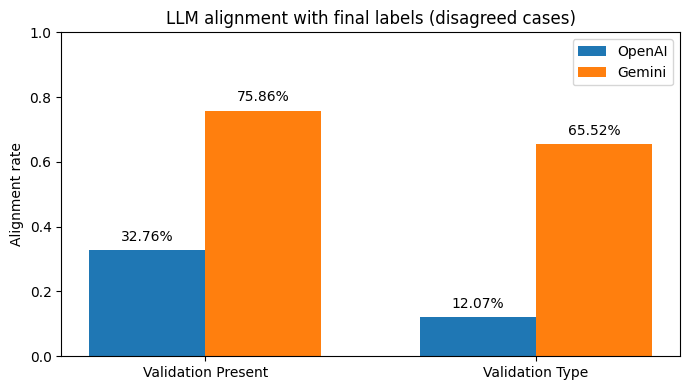

In [24]:
# ============================================================
# Alignment with final (human-agreed) labels for disagreed LLM cases
# ============================================================
from pathlib import Path
import pandas as pd

manual_label_dir = Path("manual_label")
manual_paths = [
    manual_label_dir / "Final - Human PRs.csv",
    manual_label_dir / "Final-Agent PRs.csv",
]

def _lower_cols(df):
    df = df.copy()
    df.columns = [col.strip().lower() for col in df.columns]
    return df

def _normalize_present(series):
    normalized = series.fillna(False).astype(str).str.strip().str.lower()
    return normalized.map({
        "true": True, "false": False, "1": True, "0": False,
        "yes": True, "no": False, "y": True, "n": False,
    }).fillna(False)

def _normalize_type(series):
    return series.fillna("none").astype(str).str.strip().str.lower()

manual_frames = []
for path in manual_paths:
    df = pd.read_csv(path)
    df = _lower_cols(df)
    if "id" not in df.columns and "pr_id" in df.columns:
        df["id"] = df["pr_id"]
    if "validation_present" not in df.columns:
        df["validation_present"] = False
    if "validation_type" not in df.columns:
        df["validation_type"] = "none"
    manual_frames.append(df[["id", "validation_present", "validation_type"]])

final_data = pd.concat(manual_frames, ignore_index=True)
final_data = _lower_cols(final_data)

openai_df = _lower_cols(openai_data)
gemini_df = _lower_cols(gemini_data)
if "id" not in openai_df.columns and "pr_id" in openai_df.columns:
    openai_df["id"] = openai_df["pr_id"]
if "id" not in gemini_df.columns and "pr_id" in gemini_df.columns:
    gemini_df["id"] = gemini_df["pr_id"]

if "id" not in openai_df.columns or "id" not in gemini_df.columns:
    raise ValueError("OpenAI/Gemini data must include an id column for matching.")

comparison_columns = {
    "validation_present": _normalize_present,
    "validation_type": _normalize_type,
}

subset_cols = ["id"] + list(comparison_columns.keys())
merged = (
    openai_df[subset_cols]
    .merge(gemini_df[subset_cols], on=["id"], suffixes=("_openai", "_gemini"), how="inner")
    .merge(final_data[subset_cols], on=["id"], how="inner")
)

disagreement_mask = pd.Series(False, index=merged.index)
for col, normalizer in comparison_columns.items():
    left = normalizer(merged[f"{col}_openai"])
    right = normalizer(merged[f"{col}_gemini"])
    disagreement_mask = disagreement_mask | (left != right)

disagreed = merged[disagreement_mask].copy()
print(f"Disagreed cases with final labels: {len(disagreed)}")

metrics = {"openai": {}, "gemini": {}}
for model_key, suffix in [("openai", "openai"), ("gemini", "gemini")]:
    for col, normalizer in comparison_columns.items():
        model_vals = normalizer(disagreed[f"{col}_{suffix}"])
        final_vals = normalizer(disagreed[col])
        matches = int((model_vals == final_vals).sum())
        total = int(len(final_vals))
        rate = matches / total if total else 0.0
        metrics[model_key][col] = {"matches": matches, "total": total, "rate": rate}
        print(
            f"{model_key.upper()} {col} alignment: "
            f"{matches}/{total} ({rate * 100:.2f}%)"
        )

labels = ["validation_present", "validation_type"]
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 4))
openai_rates = [metrics["openai"][label]["rate"] for label in labels]
gemini_rates = [metrics["gemini"][label]["rate"] for label in labels]

ax.bar([i - width / 2 for i in x], openai_rates, width, label="OpenAI")
ax.bar([i + width / 2 for i in x], gemini_rates, width, label="Gemini")

ax.set_ylabel("Alignment rate")
ax.set_title("LLM alignment with final labels (disagreed cases)")
ax.set_xticks(list(x))
ax.set_xticklabels([label.replace("_", " ").title() for label in labels])
ax.set_ylim(0, 1)
ax.legend()

for i, rate in enumerate(openai_rates):
    ax.text(i - width / 2, rate + 0.02, f"{rate:.2%}", ha="center", va="bottom")
for i, rate in enumerate(gemini_rates):
    ax.text(i + width / 2, rate + 0.02, f"{rate:.2%}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [25]:
# ============================================================
# Sample 10% of agreed OpenAI/Gemini labels (human + agent)
# Match manual IDs using pr_id from results/rq4_validation_evidence_final.parquet
# ============================================================
import csv
import random
from pathlib import Path

SAMPLE_RATE = 0.10
RNG = random.Random(42)
OUTPUT_PATH = Path("agreed_llm_samples_10pct.csv")

def _lower_cols(df):
    df = df.copy()
    df.columns = [col.strip().lower() for col in df.columns]
    return df

def _normalize_id_series(series):
    def _norm(value):
        if value is None or (isinstance(value, float) and pd.isna(value)):
            return ""
        text = str(value).strip()
        if text.endswith(".0"):
            try:
                return str(int(float(text)))
            except Exception:
                return text
        return text
    return series.apply(_norm)

def _normalize_present(series):
    normalized = series.fillna(False).astype(str).str.strip().str.lower()
    return normalized.map({
        "true": True, "false": False, "1": True, "0": False,
        "yes": True, "no": False, "y": True, "n": False,
    }).fillna(False)

def _normalize_type(series):
    return series.fillna("none").astype(str).str.strip().str.lower()

def _coalesce_columns(df, candidates):
    combined = pd.Series(pd.NA, index=df.index)
    for col in candidates:
        if col in df.columns:
            series = df[col]
            combined = combined.where(combined.notna(), series)
    return combined

final_path = Path("results/rq4_validation_evidence_final.parquet")
final_df = pd.read_parquet(final_path)
final_df = _lower_cols(final_df)
if "pr_id" not in final_df.columns:
    raise ValueError("Expected pr_id in results/rq4_validation_evidence_final.parquet")
if "author_type" not in final_df.columns:
    raise ValueError("Expected author_type in results/rq4_validation_evidence_final.parquet")
final_df["pr_id"] = _normalize_id_series(final_df["pr_id"])
author_type = final_df["author_type"].astype(str).str.lower()
human_ids = set(final_df[author_type.str.contains("human", na=False)]["pr_id"])
agent_ids = set(final_df[author_type.str.contains("agent", na=False)]["pr_id"])

openai_df = _lower_cols(openai_data)
gemini_df = _lower_cols(gemini_data)

if "pr_id" not in openai_df.columns or "pr_id" not in gemini_df.columns:
    raise ValueError("OpenAI/Gemini data must include a pr_id column for matching.")

openai_df["pr_id"] = _normalize_id_series(openai_df["pr_id"])
gemini_df["pr_id"] = _normalize_id_series(gemini_df["pr_id"])

comparison_columns = {
    "validation_present": _normalize_present,
    "validation_type": _normalize_type,
}

subset_cols = ["pr_id"] + list(comparison_columns.keys())
merged = (
    openai_df[subset_cols]
    .merge(gemini_df[subset_cols], on=["pr_id"], suffixes=("_openai", "_gemini"), how="inner")
)

agreement_mask = pd.Series(True, index=merged.index)
for col, normalizer in comparison_columns.items():
    left = normalizer(merged[f"{col}_openai"])
    right = normalizer(merged[f"{col}_gemini"])
    agreement_mask = agreement_mask & (left == right)

agreed = merged[agreement_mask].copy()
agreed["pr_id"] = _normalize_id_series(agreed["pr_id"])

url_candidates = ["html_url", "issue_url", "url", "pr_url", "pull_request_url"]
openai_urls = _coalesce_columns(openai_df, url_candidates)
gemini_urls = _coalesce_columns(gemini_df, url_candidates)

openai_url_map = openai_df.assign(html_url=openai_urls).set_index("pr_id")["html_url"]
gemini_url_map = gemini_df.assign(html_url=gemini_urls).set_index("pr_id")["html_url"]

def _pick_url(pr_id):
    url = openai_url_map.get(pr_id)
    if isinstance(url, str) and url.strip():
        return url.strip()
    url = gemini_url_map.get(pr_id)
    if isinstance(url, str) and url.strip():
        return url.strip()
    return ""

def _sample_ids(pool_ids):
    pool_ids = list(pool_ids)
    sample_size = max(1, int(len(pool_ids) * SAMPLE_RATE)) if pool_ids else 0
    if sample_size == 0:
        return []
    return RNG.sample(pool_ids, sample_size)

agreed_ids = set(agreed["pr_id"])
human_pool = sorted(agreed_ids & human_ids)
agent_pool = sorted(agreed_ids & agent_ids)

human_sample = _sample_ids(human_pool)
agent_sample = _sample_ids(agent_pool)

def _build_rows(ids):
    rows = []
    for pr_id in ids:
        row = agreed[agreed["pr_id"] == pr_id].iloc[0]
        rows.append({
            "id": pr_id,
            "html_url": _pick_url(pr_id),
            "validation_present": _normalize_present(pd.Series([row["validation_present_openai"]])).iloc[0],
            "validation_type": _normalize_type(pd.Series([row["validation_type_openai"]])).iloc[0],
        })
    return rows

rows = []
rows.extend(_build_rows(human_sample))
rows.extend(_build_rows(agent_sample))

with OUTPUT_PATH.open("w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["id", "html_url", "validation_present", "validation_type"])
    writer.writeheader()
    writer.writerows(rows)

print(f"Human agreed total: {len(human_pool)}, sampled: {len(human_sample)}")
print(f"Agent agreed total: {len(agent_pool)}, sampled: {len(agent_sample)}")
print(f"Saved {len(rows)} rows to {OUTPUT_PATH}")


Human agreed total: 68, sampled: 6
Agent agreed total: 231, sampled: 23
Saved 29 rows to agreed_llm_samples_10pct.csv
